<a href="https://colab.research.google.com/github/Sanjaykumar030/MY_First_ML_Model/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing**

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Chennai houseing sale.csv to Chennai houseing sale.csv


## Modules and Libraries

In [2]:
# Chennai House Price Prediction
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

# **Data Manipulation**

In [3]:
# Load Data
df = pd.read_csv("Chennai houseing sale.csv")
df.columns = df.columns.str.strip()  # Remove leading/trailing spaces

# Handle Dates
df['DATE_SALE'] = pd.to_datetime(df['DATE_SALE'], errors='coerce')
df['DATE_BUILD'] = pd.to_datetime(df['DATE_BUILD'], errors='coerce', dayfirst=True)
df['AGE_AT_SALE'] = (df['DATE_SALE'] - df['DATE_BUILD']).dt.days // 365
df['AGE_AT_SALE'] = df['AGE_AT_SALE'].fillna(df['AGE_AT_SALE'].median())

# Drop unused columns
df.drop(columns=['PRT_ID', 'DATE_SALE', 'DATE_BUILD', 'REG_FEE', 'COMMIS'], inplace=True, errors='ignore')

# Drop rows with any missing values (you could also choose to fill them)
df.dropna(inplace=True)

# One-hot encode categorical variables
cat_cols = ['AREA', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)


## Features and Scaling

In [4]:

# Separate features and target
X = df.drop(columns=['SALES_PRICE'])
y = np.log1p(df['SALES_PRICE'])  # log1p to reduce skew

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# **Training and Testing**

In [5]:

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Build XGBoost model
model = XGBRegressor(
    n_estimators=600,
    max_depth=6,
    learning_rate=0.03,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)

model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

# **Prediction and Evalution**

In [6]:
# Predictions
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_orig = np.expm1(y_test)

# Evaluation
mse = mean_squared_error(y_test_orig, y_pred)
r2 = r2_score(y_test_orig, y_pred)

print(f"Mean Squared Error: {mse:,.2f}")
print(f"R-squared: {r2:.4f}")

Mean Squared Error: 81,378,688,076.53
R-squared: 0.9945


## Features Importance Plot

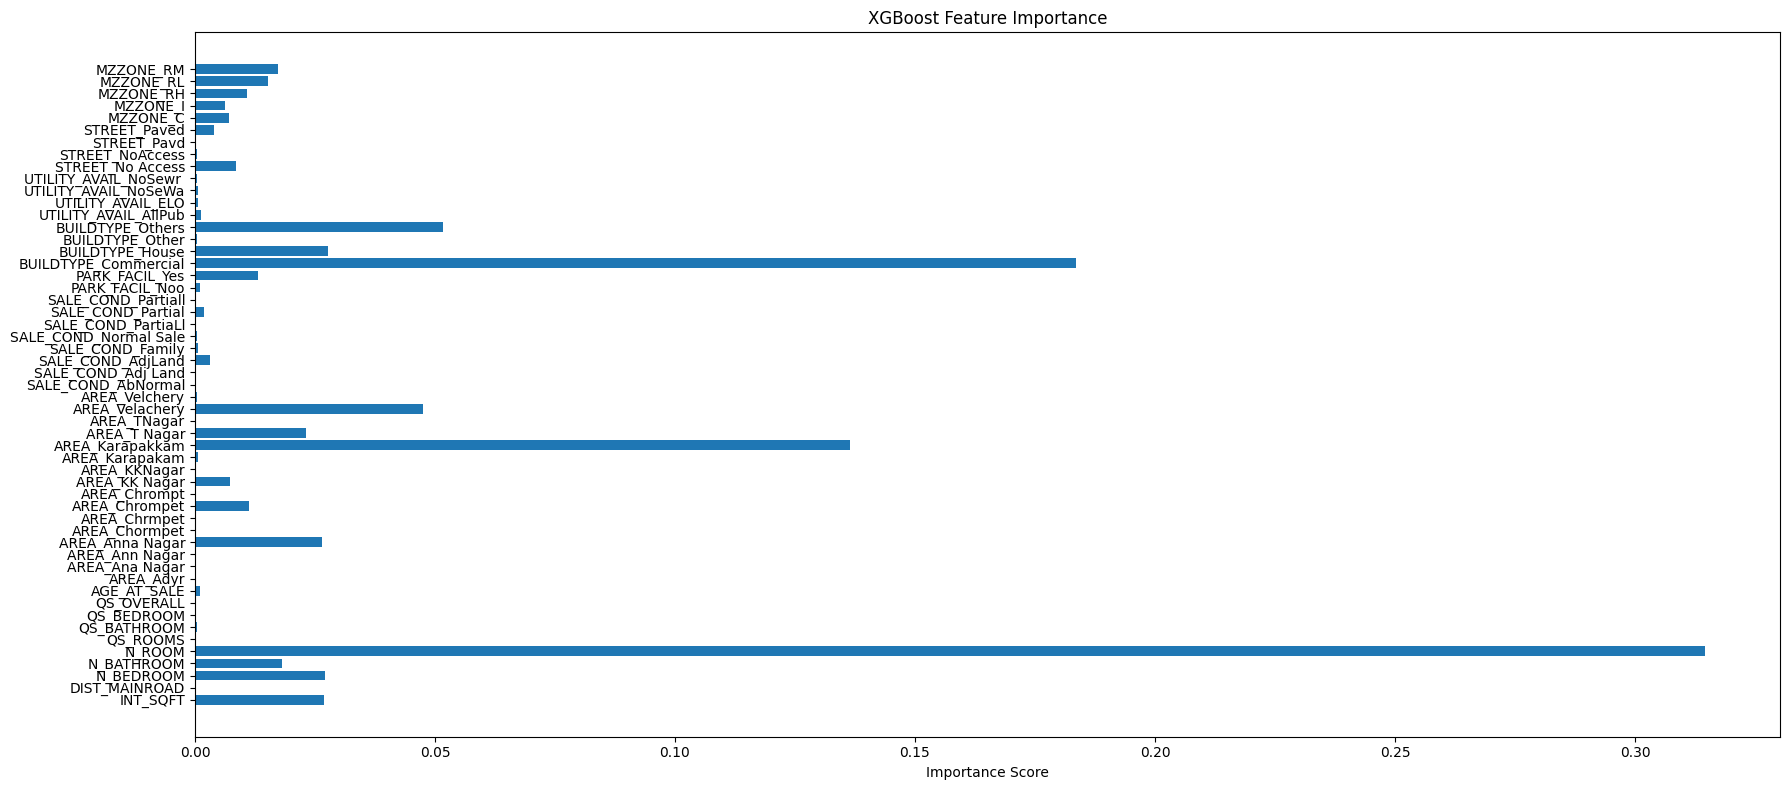

In [7]:
# Optional: Feature Importance Plot
plt.figure(figsize=(18, 8))
plt.barh(X.columns, model.feature_importances_)
plt.title("XGBoost Feature Importance")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()



# **Prediction with New Data**

In [12]:
# New Chrompet house data
new_house_input = {
    'PRT_ID': 'P00219',
    'AREA': 'Chrompet',
    'INT_SQFT': 1200,
    'DATE_SALE': '11-09-2014',
    'DIST_MAINROAD': 36,
    'N_BEDROOM': 2,
    'N_BATHROOM': 1,
    'N_ROOM': 3,
    'SALE_COND': 'Partial',
    'PARK_FACIL': 'No',
    'DATE_BUILD': '12-09-2009',
    'BUILDTYPE': 'Commercial',
    'UTILITY_AVAIL': 'NoSeWa',
    'STREET': 'No Access',
    'MZZONE': 'RH',
    'QS_ROOMS': 4.5,
    'QS_BATHROOM': 2.6,
    'QS_BEDROOM': 3.1,
    'QS_OVERALL': 3.32,
    'REG_FEE': 409027,
    'COMMIS': 198316,
}

# Convert to DataFrame
input_df = pd.DataFrame([new_house_input])

# Convert date columns
input_df['DATE_SALE'] = pd.to_datetime(input_df['DATE_SALE'], dayfirst=True)
input_df['DATE_BUILD'] = pd.to_datetime(input_df['DATE_BUILD'], dayfirst=True, errors='coerce')

# Compute AGE_AT_SALE
input_df['AGE_AT_SALE'] = (input_df['DATE_SALE'] - input_df['DATE_BUILD']).dt.days // 365
input_df['AGE_AT_SALE'] = input_df['AGE_AT_SALE'].fillna(df['AGE_AT_SALE'].median())

# Drop unused columns
input_df.drop(columns=['PRT_ID', 'DATE_SALE', 'DATE_BUILD', 'REG_FEE', 'COMMIS'], inplace=True, errors='ignore')

# One-hot encode categorical variables
cat_cols = ['AREA', 'SALE_COND', 'PARK_FACIL', 'BUILDTYPE', 'UTILITY_AVAIL', 'STREET', 'MZZONE']
input_df = pd.get_dummies(input_df, columns=cat_cols, drop_first=True)

# Add missing training columns if needed
for col in df.drop(columns=['SALES_PRICE']).columns:
    if col not in input_df.columns:
        input_df[col] = 0

# Reorder columns
X_cols = df.drop(columns=['SALES_PRICE']).columns
input_df = input_df[X_cols]

# Scale and predict
X_scaled = scaler.transform(input_df)
log_price = model.predict(X_scaled)[0]
predicted_price = np.expm1(log_price)

print(f"\n🏠 Predicted Price for Chrompet House: ₹{predicted_price:,.2f}")



🏠 Predicted Price for Chrompet House: ₹8,481,741.00
